# Read the files

In [1]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")
library("parallelMap")
library("ggthemr")

ggthemr("fresh")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: ParamHelpers

Attaching package: ‘mlr’

The following object is masked from ‘package:caret’:

    train

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

In [2]:
parallelStartSocket(cpus = 39)
#parallelStartMulticore(cpus = 39)

Starting parallelization in mode=socket with cpus=39.


In [3]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [4]:
cols_with_low_iv_values %>% cat(sep = " \n ")

nbrhud_comm_180d_violation_cnt 
 zone_type 
 mos_species 
 ses_lt_hs_pct_tract2017 
 loc_lat_lng_src 
 nbrhud_blk_grp_180d_violation_cnt 
 nbrhud_zipcode_180d_violation_cnt 
 t_day_of_yr 
 trap_trap_type 
 mos_salinarius_num_mosquitos 
 mos_unspecified_num_mosquitos 
 mos_erraticus_num_mosquitos 
 mos_tarsalis_num_mosquitos 
 trap_satellite_ind 
 t_day 
 mos_territans_num_mosquitos 
 nbrhud_comm_180d_vacancies_cnt 
 wea_ohare_tavg2_ma7 
 nbrhud_blk_grp_180d_vacancies_cnt 
 nbrhud_zipcode_180d_vacancies_cnt 
 wea_ohare_prcp 
 googtrend_deadbirds 
 wea_ohare_prcp_sum7 
 mos_restuans_num_mosquitos 
 wea_ohare_tavg2_ma60_lag21 
 wea_ohare_tmax 
 wea_ohare_prcp_sum60_lag7


# Little cleanup

In [5]:
# Remove cols_with_low_iv_values to make life a bit simplier

#df_train = df_train %>% select(-cols_with_low_iv_values)
#df_val = df_val %>% select(-cols_with_low_iv_values)

In [6]:
df_train = df_train %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)
df_val = df_val %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)

In [7]:
stopifnot(df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x))) == 
              df_val %>% select_if(is.factor) %>% map_int(~length(levels(.x))))

### Remove NA rows from val set

In [8]:
df_val = df_val[complete.cases(df_val),]

### Make y the 1st col

In [9]:
make_resp_first_var = function(df){
    pred_cols = names(df %>% select(-y))
    df %>% select(y, pred_cols)
}

In [10]:
df_train = df_train %>% make_resp_first_var
df_val   = df_val   %>% make_resp_first_var

In [11]:
dim(df_train)

[1] 15257    64

In [12]:
dim(df_val)

[1] 5903   64

In [13]:
predictors = df_train %>% select(-y) %>% names

Number of levels of all factor vars:

In [14]:
df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x)))

y             t_mo            t_qtr t_day_of_wk_name 
               2                6                3                5 
 loc_lat_lng_src      loc_zipcode       zone_class        zone_type 
               2               47               38                7 
  trap_trap_type      mos_species 
               4                8

## Putting train & val data together

Since `mlr` can handle these data together (much easier) using either holdout, or 5-fold CV, I'm putting these two sets together again.

In [15]:
df_model = df_train %>% bind_rows(df_val)

In [16]:
dim(df_model)

[1] 21160    64

In [17]:
cat("Holdout % : ", round(nrow(df_train)/nrow(df_model),3))

Holdout % :  0.721

# Model Setup

## Preprocess Data

In [18]:
wnv = createDummyFeatures(df_model,target = "y")
wnv = removeConstantFeatures(wnv)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


In [19]:
dim(wnv)

[1] 21160   173

Creating data with **NO** mosquito variables - like mos species count, or mos species information 

In [20]:
df_model_no_mos = df_model %>% select(-starts_with("mos"),-woe_mos_species) %>% distinct()
wnv_no_mos = createDummyFeatures(df_model_no_mos,target = "y")
wnv_no_mos = removeConstantFeatures(wnv_no_mos)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


In [21]:
dim(wnv_no_mos)

[1] 11583   155

Creating data with **NO** species variables but including the mos species count

In [22]:
df_model_no_mos = df_model %>% select(-starts_with("mos"),-woe_mos_species) %>% bind_cols(df_model["mos_tot_num_mosquitos"]) %>% distinct()
wnv_mos_count = createDummyFeatures(df_model_no_mos,target = "y")
wnv_mos_count = removeConstantFeatures(wnv_mos_count)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


In [23]:
dim(wnv_mos_count)

[1] 11591   156

## Create Classification Task & Split

In [24]:
tsk = makeClassifTask(data = wnv, target = "y", positive = "Infected")
tsk

Supervised task: wnv
Type: classif
Target: y
Observations: 21160
Features:
   numerics     factors     ordered functionals 
        172           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   18175     2985 
Positive class: Infected

In [25]:
tsk_no_mos = makeClassifTask(data = wnv_no_mos, target = "y", positive = "Infected")
tsk_no_mos

Supervised task: wnv_no_mos
Type: classif
Target: y
Observations: 11583
Features:
   numerics     factors     ordered functionals 
        154           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   10284     1299 
Positive class: Infected

In [26]:
tsk_mos_count = makeClassifTask(data = wnv_mos_count, target = "y", positive = "Infected")
tsk_mos_count

Supervised task: wnv_mos_count
Type: classif
Target: y
Observations: 11591
Features:
   numerics     factors     ordered functionals 
        155           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   10291     1300 
Positive class: Infected

# Feature Importance

In [364]:
fv = generateFilterValuesData(tsk, method = "anova.test")
fv

FilterValues:
Task: wnv
         name    type anova.test
1       t_day integer   5.763191
2        t_wk integer 336.653767
3 t_day_of_yr integer 371.103321
4 t_day_of_wk integer  69.448454
5  t_eval_day integer 521.900156
6   t_eval_wk integer 521.824912
... (#rows: 172, #cols: 3)

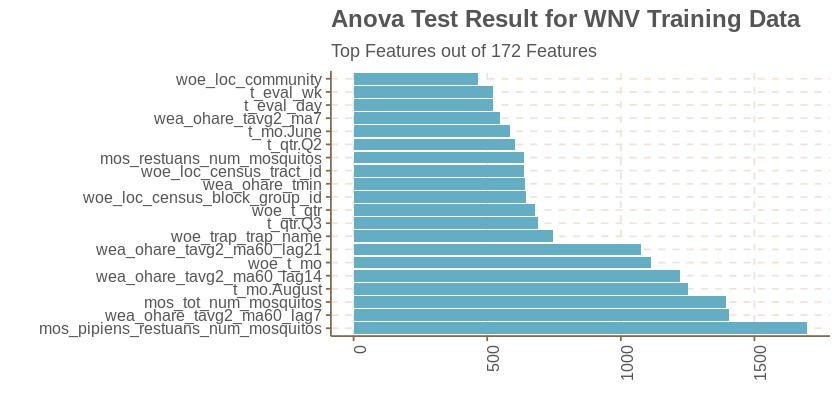

In [365]:
options(repr.plot.width=7, repr.plot.height=3.5)
plotFilterValues(fv) + 
    labs(title="Anova Test Result for WNV Training Data", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

fv = generateFilterValuesData(tsk, method = c("randomForest.importance"))
fv

plotFilterValues(fv,facet.wrap.nrow = 2) + 
    labs(title="Random Forest Importance Plot", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

## Build the model

In [27]:
rdesc = makeResampleDesc("Holdout", stratify = FALSE, split = 0.721)

In [28]:
lrns = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob"),
            makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
            makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
            makeLearner(id = "adaboost", cl = "classif.adaboostm1", predict.type = "prob"),
            makeLearner(id = "cforest", cl = "classif.cforest", predict.type = "prob"),
            makeLearner(id = "C50", cl = "classif.C50", predict.type = "prob"),
            makeLearner(id = "gbm", cl = "classif.gbm", predict.type = "prob"),
            makeLearner(id = "dbnDNN", cl = "classif.dbnDNN", predict.type = "prob"),
            makeLearner(id = "svm", cl = "classif.svm", predict.type = "prob"),
            makeLearner(id = "svm_radial", cl = "classif.svm", predict.type = "prob", kernel = "radial"),
            makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

#makePreprocWrapperCaret(makeLearner(id = "eTrees_norm","classif.evtree",predict.type = "prob"), ppc.center = TRUE, ppc.scale = TRUE)

In [29]:
meas = list(auc, mmce, f1, tpr, fpr, fnr, timetrain, kappa)

In [44]:
bmr = readRDS('large_cache/bmr_001.RData')
#parallelStartSocket(cpus = 39)
#bmr = benchmark(learners = lrns, tasks = tsk, resamplings = rdesc, measures = meas, show.info = TRUE)
#parallelStop()

Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 11.


In [30]:
lrns_2 = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob"),
              makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
              makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
              makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

parallelStartSocket(cpus = 39)
bmr_no_mos = benchmark(learners = lrns_2, tasks = tsk_no_mos, resamplings = rdesc, measures = meas, show.info = TRUE)
parallelStop()

Warning message in parallelStart(mode = MODE_SOCKET, cpus = cpus, socket.hosts = socket.hosts, :
“Parallelization was not stopped, doing it now.”Stopped parallelization. All cleaned up.
Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 4.
Stopped parallelization. All cleaned up.


In [31]:
parallelStartSocket(cpus = 39)
bmr_mos_count = benchmark(learners = lrns_2, tasks = tsk_mos_count, resamplings = rdesc, measures = meas, show.info = TRUE)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 4.
Stopped parallelization. All cleaned up.


In [371]:
bmr

   task.id learner.id auc.test.mean mmce.test.mean f1.test.mean tpr.test.mean
1      wnv      rpart     0.7816962     0.10721545    0.5043070     0.3865546
2      wnv         rf     0.9816441     0.02726965    0.8961960     0.8343337
3      wnv        xgb     0.8963596     0.10044038    0.5668371     0.4657863
4      wnv   adaboost     0.8756317     0.11500678    0.4211424     0.2965186
5      wnv    cforest     0.9341287     0.10924797    0.3909348     0.2484994
6      wnv        C50     0.9078098     0.07859079    0.6890080     0.6170468
7      wnv        gbm     0.7784532     0.14109079    0.0000000     0.0000000
8      wnv     dbnDNN     0.5000000     0.14109079    0.0000000     0.0000000
9      wnv        svm     0.9647349     0.03743225    0.8507765     0.7563025
10     wnv svm_radial     0.9646048     0.03726287    0.8517520     0.7587035
11     wnv extraTrees     0.9859502     0.02625339    0.9014622     0.8511405
   fpr.test.mean fnr.test.mean timetrain.test.mean
1    0.024058

In [321]:
bmr_no_mos

     task.id learner.id auc.test.mean mmce.test.mean f1.test.mean tpr.test.mean
1 wnv_no_mos      rpart     0.7742571     0.12787940    0.3028624     0.1968788
2 wnv_no_mos         rf     0.9743840     0.04098916    0.8456633     0.7959184
3 wnv_no_mos        xgb     0.8415894     0.12720190    0.4245211     0.3325330
4 wnv_no_mos extraTrees     0.9870184     0.03082656    0.8870968     0.8583433
  fpr.test.mean fnr.test.mean timetrain.test.mean kappa.test.mean
1    0.01695918     0.8031212               1.639       0.2542876
2    0.01419838     0.2040816              73.794       0.8221368
3    0.03845395     0.6674670               0.307       0.3591113
4    0.01262078     0.1416567               3.924       0.8692698

In [374]:
bmr_no_mos

     task.id learner.id auc.test.mean mmce.test.mean f1.test.mean tpr.test.mean
1 wnv_no_mos      rpart     0.7773596      0.1092203    0.2982107     0.2005348
2 wnv_no_mos         rf     0.8580334      0.1011757    0.3955638     0.2860963
3 wnv_no_mos        xgb     0.8320541      0.1101485    0.2489451     0.1577540
4 wnv_no_mos extraTrees     0.8340080      0.1073639    0.4168067     0.3315508
  fpr.test.mean fnr.test.mean timetrain.test.mean kappa.test.mean
1    0.01889433     0.7994652               0.555       0.2539282
2    0.02099370     0.7139037              32.867       0.3490597
3    0.01434570     0.8422460               0.100       0.2103917
4    0.03393982     0.6684492               1.973       0.3619596

In [322]:
bmr_mos_count

        task.id learner.id auc.test.mean mmce.test.mean f1.test.mean
1 wnv_mos_count      rpart     0.7703800     0.11246612    0.4820593
2 wnv_mos_count         rf     0.9767971     0.03810976    0.8560461
3 wnv_mos_count        xgb     0.8812736     0.10535230    0.5525180
4 wnv_mos_count extraTrees     0.9840616     0.03404472    0.8744535
  tpr.test.mean fpr.test.mean fnr.test.mean timetrain.test.mean kappa.test.mean
1     0.3656805   0.025301443     0.6343195               2.107       0.4260575
2     0.7917160   0.009685709     0.2082840              74.220       0.8342511
3     0.4544379   0.031824471     0.5455621               0.332       0.4959463
4     0.8284024   0.011069381     0.1715976               3.989       0.8548315

In [375]:
bmr_mos_count

        task.id learner.id auc.test.mean mmce.test.mean f1.test.mean
1 wnv_mos_count      rpart     0.7519918     0.08843537    0.4562738
2 wnv_mos_count         rf     0.8998388     0.08534323    0.4926471
3 wnv_mos_count        xgb     0.8916954     0.09059988    0.4643510
4 wnv_mos_count extraTrees     0.8839984     0.09276438    0.4863014
  tpr.test.mean fpr.test.mean fnr.test.mean timetrain.test.mean kappa.test.mean
1     0.3361345    0.01703163     0.6638655               0.521       0.4147599
2     0.3753501    0.01842197     0.6246499              32.877       0.4509804
3     0.3557423    0.02189781     0.6442577               0.147       0.4198617
4     0.3977591    0.02954466     0.6022409               1.992       0.4380793

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

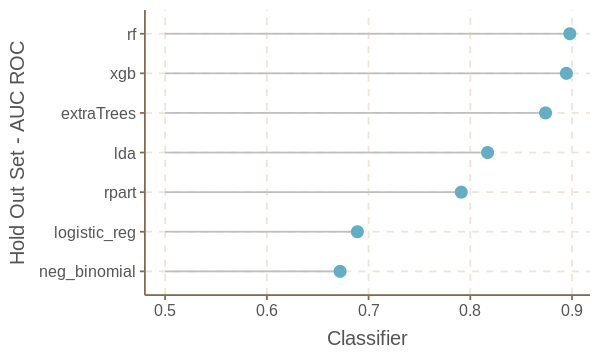

In [48]:
options(repr.plot.width=5, repr.plot.height=3)

getBMRAggrPerformances(bmr_mos_count, as.df = T) %>%
    select(learner.id,auc.test.mean) %>%
    bind_rows(list(learner.id="logistic_reg",auc.test.mean=0.689),
             list(learner.id="lda",auc.test.mean=0.817),
             list(learner.id="neg_binomial",auc.test.mean=0.672))%>%
    mutate(learner.id = forcats::fct_reorder(learner.id,auc.test.mean,.desc = F)) %>%
    ggplot(aes(learner.id, auc.test.mean))+
    geom_segment(aes(xend=learner.id,yend=0.5),color="gray")+
    geom_point(size=3)+
    coord_flip()+
    labs(x="Hold Out Set - AUC ROC",y="Classifier")

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

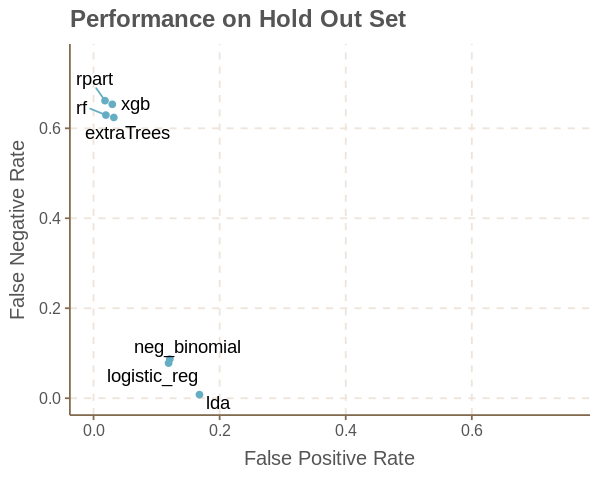

In [65]:
library("ggrepel")
ggthemr("fresh")
options(repr.plot.width=5, repr.plot.height=4)
getBMRAggrPerformances(bmr_mos_count, as.df = T) %>%
    select(learner.id,fpr.test.mean,fnr.test.mean) %>%
    bind_rows(list(learner.id="logistic_reg",fpr.test.mean=.119,fnr.test.mean=.078),
             list(learner.id="lda",fpr.test.mean=0.168,fnr.test.mean=.008),
             list(learner.id="neg_binomial",fpr.test.mean=0.121,fnr.test.mean=.087))%>%
    ggplot(aes(x=fpr.test.mean, y=fnr.test.mean)) +
    geom_point()+#(aes(color=learner.id))+
    geom_text_repel(aes(label=learner.id),force = 4,segment.colour = "#65ADC2")+
    theme(legend.position = "none")+
    scale_y_continuous(limits = c(0,.75))+
    scale_x_continuous(limits = c(0,.75))+
    labs(x="False Positive Rate", y="False Negative Rate", title = "Performance on Hold Out Set")

In [66]:
df = generateThreshVsPerfData(bmr_mos_count, measures = list(fpr, tpr, mmce))

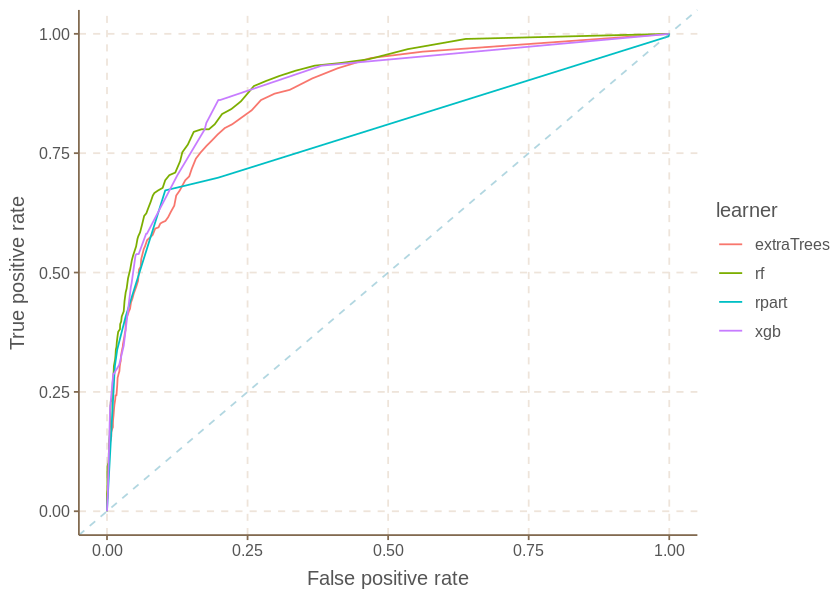

In [67]:
options(repr.plot.width=7, repr.plot.height=5)
plotROCCurves(df)

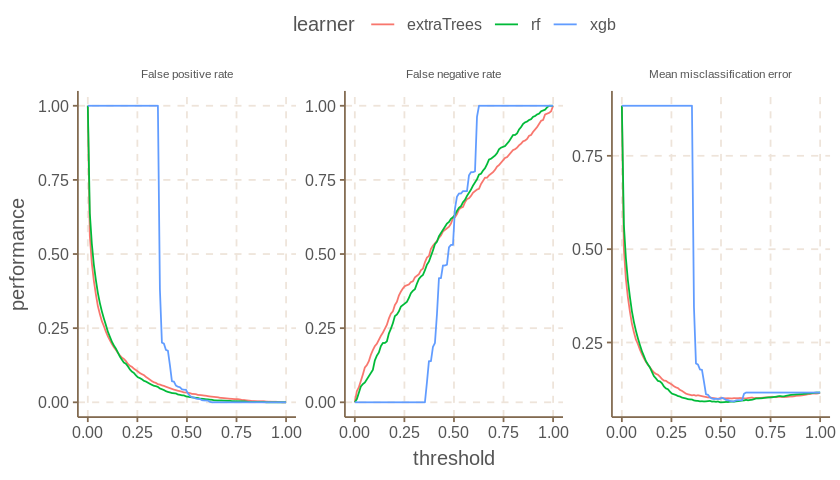

In [72]:
options(repr.plot.width=7, repr.plot.height=4)
generateThreshVsPerfData(obj = bmr_mos_count$results$wnv[c("extraTrees","xgb","rf")],measures = list(fpr, fnr, mmce)) %>%
    plotThreshVsPerf() +
    theme(strip.text.x = element_text(size = 7), legend.position = "top")

In [100]:
saveRDS(object = bmr, file = "bmr_001.RData")

# Tuning

The extraTrees model seems to be the best. Can tuning make the performance better?

Without tuning, the baseline result...

In [383]:
preds = getBMRPredictions(bmr, learner.ids = "extraTrees",drop = T)

In [384]:
calculateROCMeasures(preds)

          predicted
true       Clean     Infected                         
  Clean    5040      31        tpr: 0.85   fnr: 0.15  
  Infected 124       709       fpr: 0.01   tnr: 0.99  
           ppv: 0.96 for: 0.02 lrp: 139.23 acc: 0.97  
           fdr: 0.04 npv: 0.98 lrm: 0.15   dor: 929.59


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [385]:
ctrl = makeTuneControlGrid()
ctrl

Tune control: TuneControlGrid
Same resampling instance: TRUE
Imputation value: <worst>
Start: <NULL>

Tune threshold: FALSE
Further arguments: resolution=10

In [386]:
getLearnerParamSet("classif.extraTrees")

                           Type  len   Def         Constr Req Tunable Trafo
ntree                   integer    -   500       1 to Inf   -    TRUE     -
mtry                    integer    -     -       1 to Inf   -    TRUE     -
nodesize                integer    -     1    -Inf to Inf   -    TRUE     -
numRandomCuts           integer    -     1    -Inf to Inf   -    TRUE     -
evenCuts                logical    - FALSE              -   -    TRUE     -
numThreads              integer    -     1       1 to Inf   -    TRUE     -
subsetSizes       integervector <NA>     -    -Inf to Inf   -    TRUE     -
subsetGroups            untyped    -     -              -   -    TRUE     -
tasks             integervector <NA>     -       1 to Inf   -    TRUE     -
probOfTaskCuts          numeric    -     -         0 to 1   -    TRUE     -
numRandomTaskCuts       integer    -     1       1 to Inf   -    TRUE     -
na.action              discrete    -  stop stop,zero,fuse   -    TRUE     -

In [387]:
ps = makeParamSet(
    makeDiscreteParam("ntree", values = c(500)),
    makeDiscreteParam("mtry", values = c(50,55,60,65)),
    makeDiscreteParam("numRandomCuts", values = c(7,10,13))
)
ps

                  Type len Def      Constr Req Tunable Trafo
ntree         discrete   -   -         500   -    TRUE     -
mtry          discrete   -   - 50,55,60,65   -    TRUE     -
numRandomCuts discrete   -   -     7,10,13   -    TRUE     -

In [ ]:
parallelStartSocket(cpus = 39)

lrn_ex = makeLearner(cl = "classif.extraTrees", predict.type = "prob")
res = tuneParams(learner = lrn_ex, task = tsk, resampling = rdesc, par.set = ps, control = ctrl, measures = meas,show.info = F)

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 12.


In [ ]:
res

In [ ]:
res_df = generateHyperParsEffectData(res,partial.dep = T)[[1]]
res_df%>%
    ggplot(aes(x=mtry, y = auc.test.mean, color = as.factor(numRandomCuts)))+
    geom_line()

In [ ]:
parallelStartSocket(cpus = 39)

lrn_ex = setHyperPars(makeLearner(cl = "classif.extraTrees", predict.type = "prob"), par.vals = res$x)
r = resample(learner = lrn_ex, task = tsk, resampling = rdesc, measures = meas)
pred = getRRPredictions(r)
calculateROCMeasures(pred)

In [ ]:
cal = generateCalibrationData(pred)
plotCalibration(cal, smooth = F)

In [ ]:
setThreshold(pred, threshold = .5) %>% calculateROCMeasures

In [ ]:
setThreshold(pred, threshold = .25) %>% calculateROCMeasures

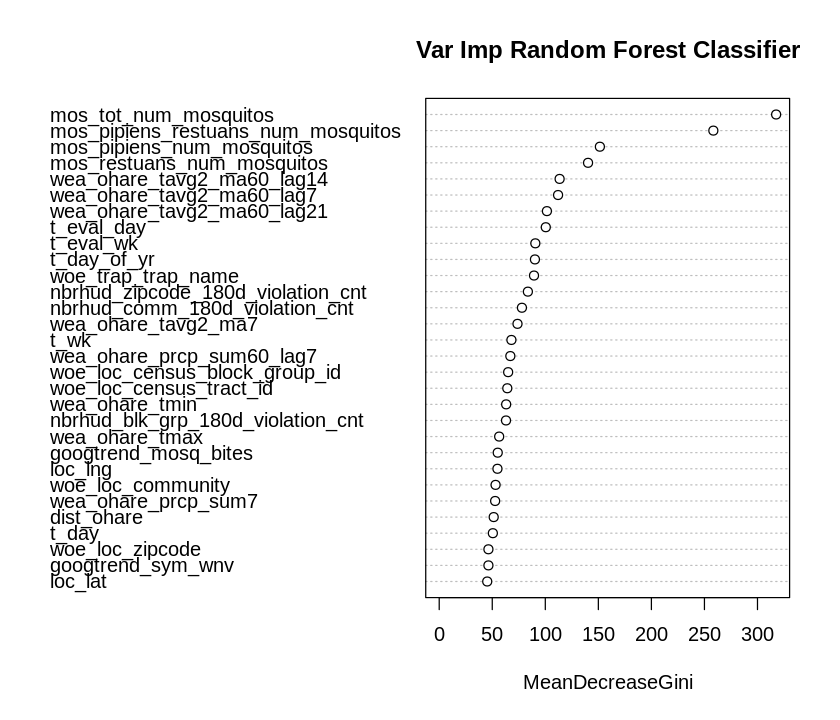

In [314]:
library("randomForest")
options(repr.plot.width=7, repr.plot.height=6)
varImpPlot(bmr$results$wnv$rf$models[[1]]$learner.model, main = "Var Imp Random Forest Classifier")

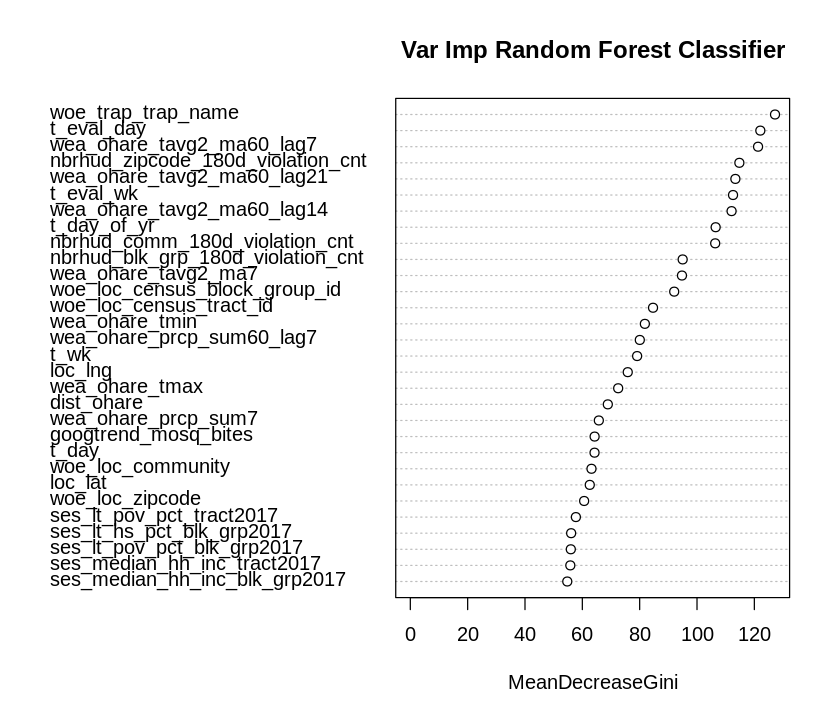

In [313]:
library("randomForest")
options(repr.plot.width=7, repr.plot.height=6)
varImpPlot(bmr_no_mos$results$wnv_no_mos$rf$models[[1]]$learner.model, main = "Var Imp Random Forest Classifier")

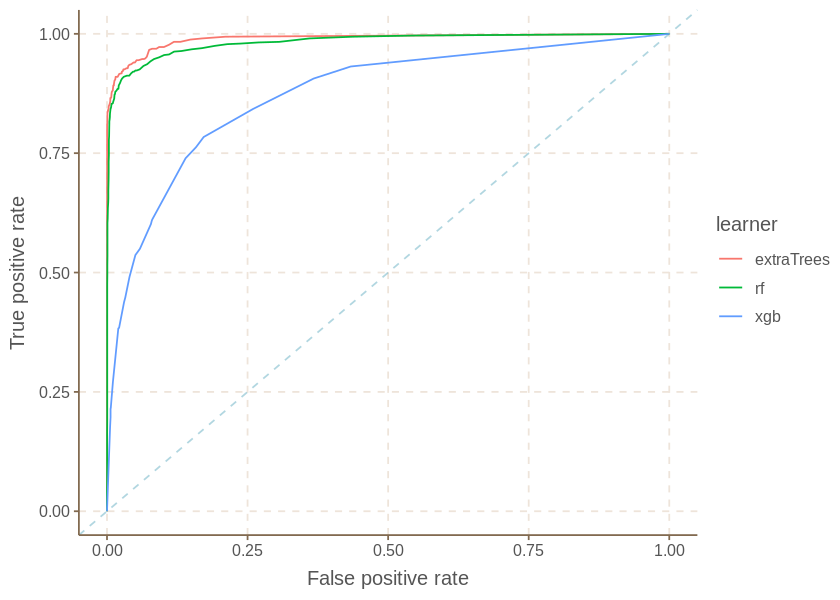

In [312]:
options(repr.plot.width=7, repr.plot.height=5)
mergeBenchmarkResults(list(bmr_no_mos,bmr_mos_count)) %>%
    generateThreshVsPerfData(measures = list(fpr, tpr, mmce)) %>%
    plotROCCurves()